In [4]:
import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Convolution3D, MaxPooling3D, UpSampling3D, GlobalAveragePooling3D, Dense, Flatten, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.optimizers import SGD, Adam, Nadam

from keras_tqdm import TQDMNotebookCallback

In [2]:
X = np.load("/mnt/data/luna16/sets/toy_set_v1_20k.npy")
y = np.zeros((20000,2))
y[:10000,0] = 1
y[10000:,1] = 1

idx = np.random.permutation(X.shape[0])
X, y = X[idx], y[idx]

In [3]:
X = (X + 693.0) / 343.0

In [22]:
vsize = (32, 32, 32)

alpha = 2

def model3d(vsize, do_features=False):
    inputs = Input(vsize + (1,))
    sz = 32

    def conv3dparams():
        return { 'activation':ELU(), 'border_mode':'valid', 'init': 'he_normal' }

    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(inputs)
    x = BatchNormalization()(x)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    sz = int(sz * alpha)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    # x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    sz = int(sz * alpha)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    # x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    sz = int(sz * alpha)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    # x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    sz = int(sz * alpha)
    # x = Convolution3D(sz, 3, 3, 3, **conv3dparams)(x)
    # x = Convolution3D(sz, 3, 3, 3, **conv3dparams)(x)
    # x = BatchNormalization()(x)

    x = Convolution3D(sz, 2, 2, 2, activation=ELU(), border_mode='valid')(x)
    x = BatchNormalization()(x)
    x = Convolution3D(2, 1, 1, 1, activation='linear', border_mode='same')(x)
    if not do_features:
        x = Flatten()(x)
        x = Activation('softmax')(x)

    model = Model(input=inputs, output=x)

    return model



In [ ]:
model = model_3d()
print(model.summary())

#sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())

batch_size=32

model.fit(
    X, 
    y, 
    batch_size=batch_size,
    nb_epoch=10,
    validation_split=0.1,
    verbose=0, callbacks=[TQDMNotebookCallback(leave_inner=True)])

In [ ]:
sgd.lr = 0.00001

model.fit(
    X, 
    y, 
    batch_size=batch_size,
    nb_epoch=3,
    validation_split=0.1,
    verbose=0, callbacks=[TQDMNotebookCallback(leave_inner=True)])

In [ ]:
np.mean(X)

In [ ]:
np.std(X)

In [ ]:
y_pred = model.predict(X[18000:], batch_size)

In [ ]:
y_true = y[18000:]
idxs = (y_true[:,1] - y_pred[:,1]).argsort()[-30:][::-1]

In [ ]:
for i in idxs:
    print(y_true[i], y_pred[i], i)

In [ ]:
from pylab import *
%matplotlib inline

In [ ]:
for i in idxs[:10]:
    imshow(X[i+18000,16,:,:,0])
    show()

In [40]:
import data

/home/alex/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [41]:
pid = data.luna16_get_patient_ids()[0]

In [139]:
image = data.luna16_get_image(pid)
image = preprocess(image)

In [141]:
cubes = []
for i in range(0, image.shape[0], 16):
    for j in range(0, image.shape[1], 8):
        for k in range(0, image.shape[2], 8):
            cube = image[i:i+32,j:j+32,k:k+32]
            if (cube.shape != (32,32,32)):
                continue
            cubes.append(cube)
cubes = np.stack(cubes)
cubes = cubes[...,None]

In [142]:
cubes.shape

(22932, 32, 32, 32, 1)

In [143]:
cps = model.predict(cubes, batch_size)

In [ ]:
np.count_nonzero(cps[:,1] > 0.5)

In [ ]:
image.shape[0] / 32, image.shape[1] / 32, image.shape[2] / 32

In [ ]:
cps = cps[:,1].reshape((7,11,11))

In [ ]:
imshow(cps[3])
colorbar()

In [10]:
model.layers[-3]

'convolution3d_10'

In [14]:
input_ = model.input
features = model.layers[-3].output
model2 = Model(input_, features)


In [16]:
model.save_weights('/mnt/data/snap/tmp.h5')

In [51]:
model2 = model3d((128,128,128), do_features=True)

In [52]:
model2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_10 (InputLayer)            (None, 128, 128, 128, 0                                            
____________________________________________________________________________________________________
convolution3d_91 (Convolution3D) (None, 126, 126, 126, 896         input_10[0][0]                   
____________________________________________________________________________________________________
batchnormalization_82 (BatchNorm (None, 126, 126, 126, 128         convolution3d_91[0][0]           
____________________________________________________________________________________________________
convolution3d_92 (Convolution3D) (None, 124, 124, 124, 27680       batchnormalization_82[0][0]      
___________________________________________________________________________________________

In [53]:
model2.load_weights('/mnt/data/snap/tmp.h5', by_name=True)

In [90]:
def preprocess(image):
    return (image + 693.0) / 343.0

In [126]:
image = preprocess(image)

In [130]:
result = model2.predict(image[115-64:115+64,130-64:130+64,130-64:130+64].reshape((1,128,128,128,1)), batch_size=1)

In [94]:
image.shape

(231, 360, 360)

In [95]:
result.shape

(1, 49, 49, 49, 2)

In [80]:
def softmax(x):
    return np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x)))

In [75]:
p = np.exp(result[...,1] - np.max(result)) / np.sum(np.exp(result - np.max(result)), -1)

/home/alex/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [131]:
p = np.zeros(result.shape).reshape((-1,2))
r = result.reshape((-1,2))
for i in range(r.shape[0]):
    p[i] = softmax(r[i])
p = p.reshape(result.shape)

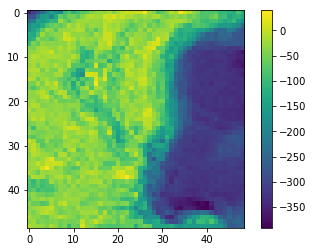

In [133]:
imshow(result[0,25,:,:,0])
colorbar()

In [60]:
from pylab import *
%matplotlib inline

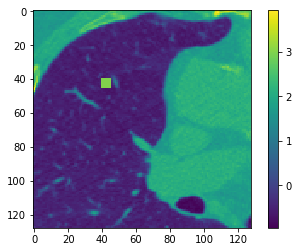

In [134]:
imshow(image[115,130-64:130+64,130-64:130+64])
colorbar()

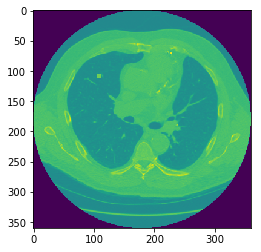

In [128]:
imshow(image[115])

In [127]:
image[115-3:115+3,130-64+40:130-64+46,130-64+40:130-64+46] = 3

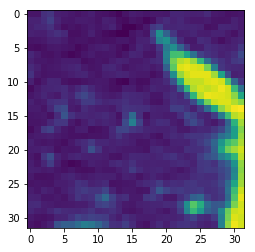

In [147]:
cube = image[115-16:115+16,150-16:150+16,120-16:120+16]
imshow(cube[16])

In [151]:
model.predict(cube.reshape((1,32,32,32,1)), batch_size=1)

array([[  9.99786198e-01,   2.13767868e-04]], dtype=float32)